# Ultimate Technologies Inc. - Take Home Challenge

## Part 1 - Exploratory Data Analysis

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [68]:
# Load data
logins = pd.read_json('logins.json')

In [69]:
# Inspect logins
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [70]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [71]:
# Set datetime column to index
logins.set_index('login_time', inplace=True)

In [72]:
# Create column of 1's representing someone logging in at that time
logins['LoginFreq']=1

In [73]:
# Resample 
logins = logins.resample('15min').count()

In [74]:
logins.head()

,LoginFreq
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<AxesSubplot:xlabel='login_time'>

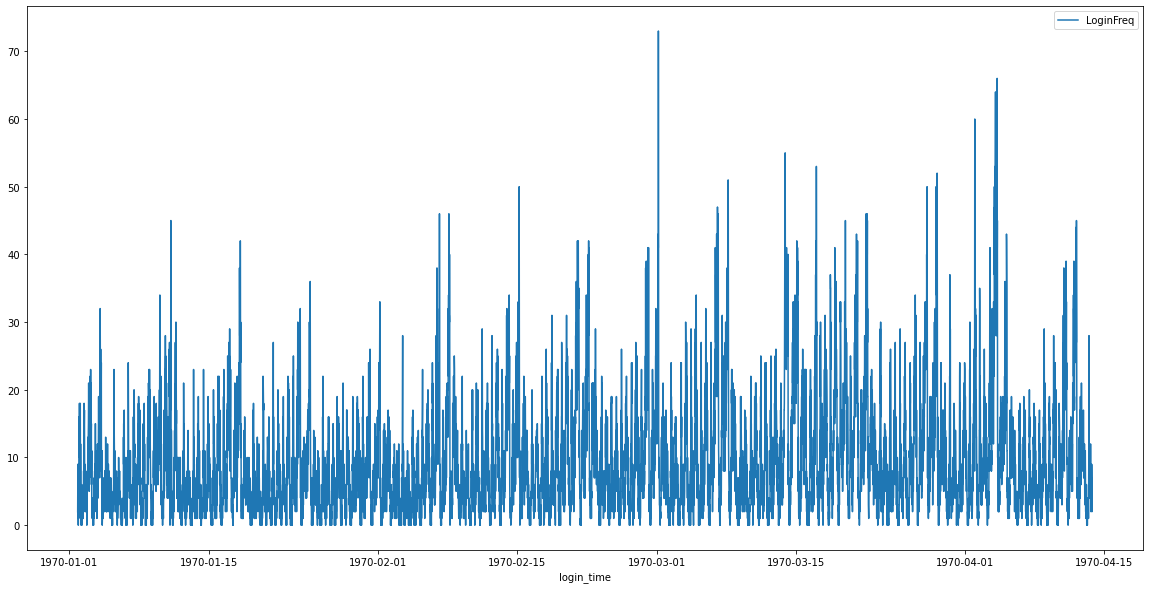

In [82]:
_ = plt.figure(figsize=(20,10))
sns.lineplot(data=logins)